In [1]:
import pandas as pd
import warnings

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

<h2>Scraping Techniques</h2>

* As was mentioned in the problem statement Data Collection was the most difficult task.
* There is plenty of data for E2Ws in India, as there are many options available also are much cheaper than E4W's 
* Different methods had to be adopted to scrape from these sites as they display information differently 
<br><br>

* `Like for` **bikewale.com** `all links of user reviews had to be extracted and then visiting each link the mentioned attributes were extracted`

<img src="images/bikeWale.png" alt="carwale" style="width: 50%;height: 40%"/>


In [3]:
df = pd.read_csv("data/bikewale.csv")

In [4]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              769 non-null    object 
 1   Used it for         812 non-null    object 
 2   Owned for           812 non-null    object 
 3   Ridden for          640 non-null    object 
 4   rating              812 non-null    int64  
 5   Visual Appeal       711 non-null    float64
 6   Reliability         688 non-null    float64
 7   Performance         624 non-null    float64
 8   Service Experience  681 non-null    float64
 9   Extra Features      568 non-null    float64
 10  Comfort             202 non-null    float64
 11  Maintenance cost    88 non-null     float64
 12  Value for Money     84 non-null     float64
dtypes: float64(8), int64(1), object(4)
memory usage: 82.6+ KB


In [6]:
df.head(10)

,review,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Comfort,Maintenance cost,Value for Money
0,Wanna buy this bike so i gave basic informatio...,Everything,Never owned,NaN,1,3.0,1.0,3.0,1.0,4.0,NaN,NaN,NaN
1,This is simply amazing and exceptionally well ...,Everything,> 1 yr,< 5000 kms,5,5.0,5.0,5.0,5.0,NaN,5.0,NaN,NaN
2,"Battery life is good, I like this bike very mu...",Everything,< 3 months,< 5000 kms,5,4.0,4.0,5.0,3.0,NaN,4.0,NaN,NaN
3,I seen this bike on road. Very nice bike and g...,Everything,Never owned,NaN,5,5.0,5.0,5.0,5.0,NaN,5.0,NaN,NaN
4,I have a rv400 I have the bike for almost more...,Daily Commute,> 1 yr,5000-10000 kms,1,2.0,1.0,1.0,2.0,NaN,3.0,NaN,NaN
5,Buying experience of Revolt 400 bike. It is us...,Leisure Rides,> 1 yr,> 15000 kms,3,1.0,5.0,1.0,1.0,NaN,3.0,NaN,NaN
6,"We'll, this bike will meet the interests of ma...",Leisure Rides,Never owned,NaN,5,4.0,4.0,4.0,4.0,4.0,NaN,5.0,NaN
7,"Buying experience is awesome, riding performan...",Daily Commute,6 months-1 yr,< 5000 kms,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Value for money. Really a thumbs up for the bi...,Everything,Never owned,NaN,5,5.0,5.0,5.0,5.0,5.0,NaN,5.0,NaN
9,"Please give protection to the battery, because...",Daily Commute,Never owned,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
for col in df.columns[1:].values:
    print(col,'\n\n' ,df[col].value_counts(), '\n\n\n')

Used it for 

 Daily Commute         581
Everything            154
Occasional Commute     52
Leisure Rides          17
Tours                   8
Name: Used it for, dtype: int64 



Owned for 

 < 3 months            211
> 1 yr                195
Never owned           171
6 months-1 yr         129
3-6 months            105
Occasional Commute      1
Name: Owned for, dtype: int64 



Ridden for 

 < 5000 kms         439
5000-10000 kms     133
> 15000 kms         37
10000-15000 kms     30
Never owned          1
Name: Ridden for, dtype: int64 



rating 

 5    323
1    232
4    146
3     65
2     46
Name: rating, dtype: int64 



Visual Appeal 

 5.0    284
4.0    195
3.0    106
1.0     88
2.0     38
Name: Visual Appeal, dtype: int64 



Reliability 

 5.0    228
1.0    172
4.0    147
3.0     90
2.0     51
Name: Reliability, dtype: int64 



Performance 

 5.0    218
4.0    172
1.0    100
3.0     84
2.0     50
Name: Performance, dtype: int64 



Service Experience 

 5.0    215
1.0    198


# Psychographic Analysis
### Here we can analyse all the preferences and reviews of the customers on various aspects.

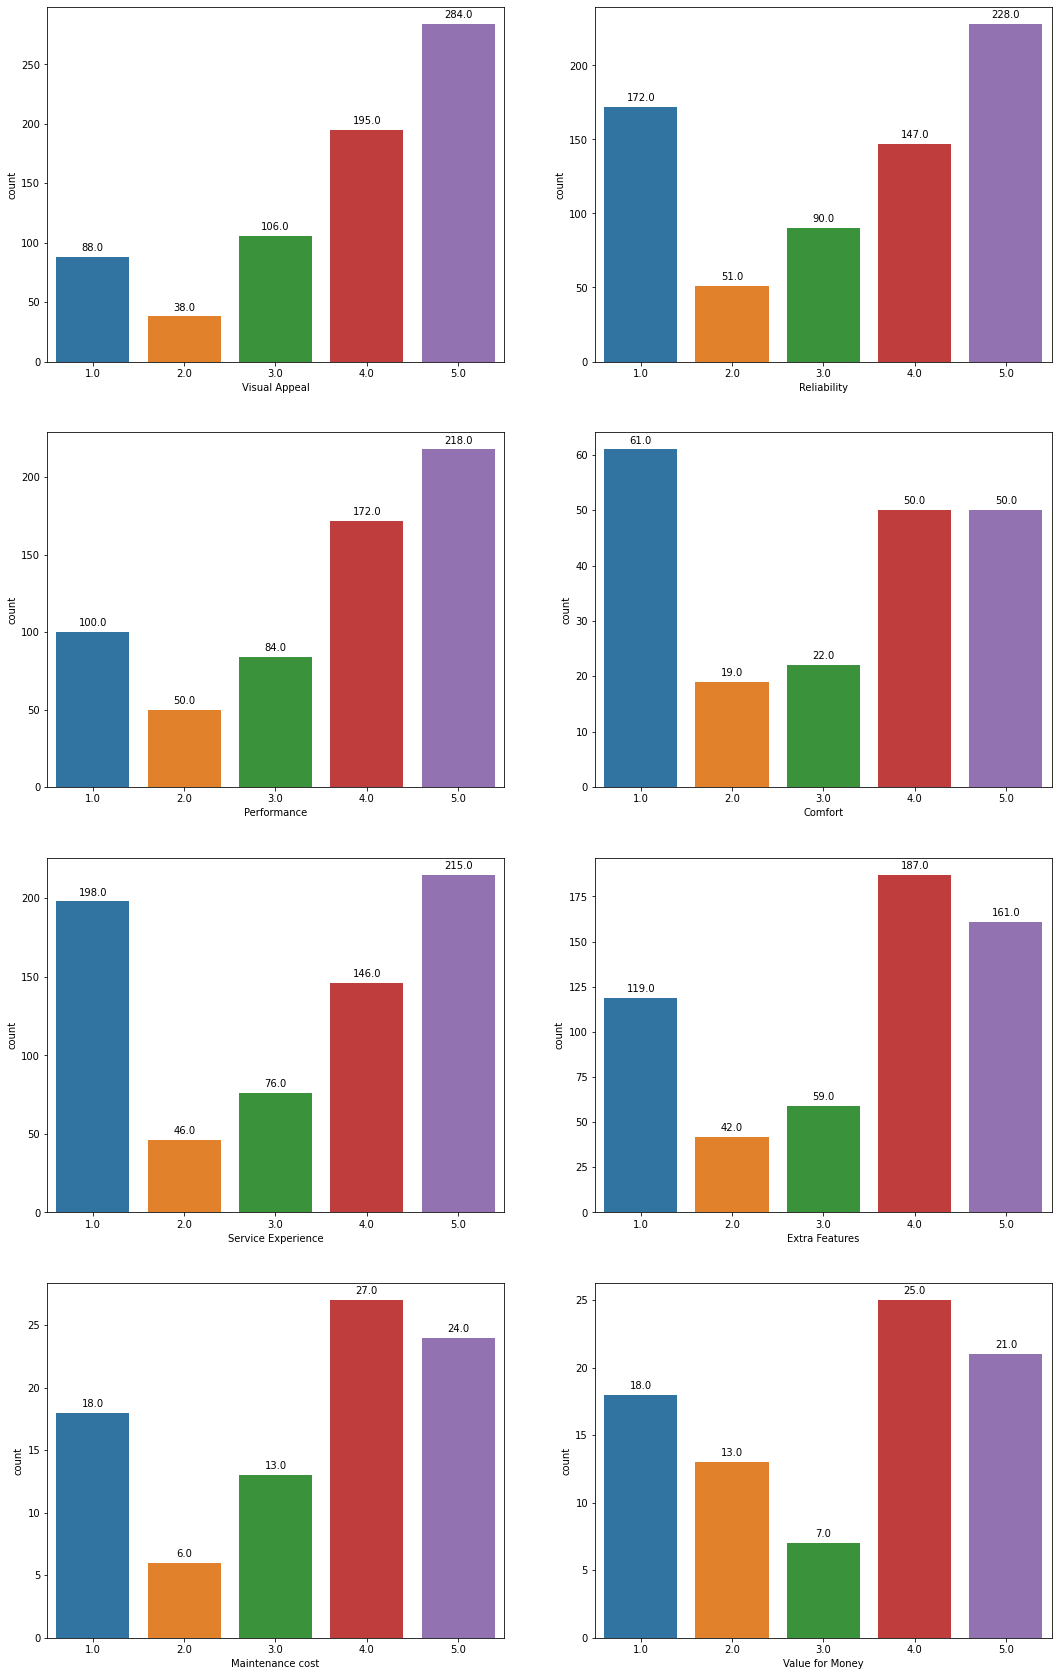

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 30))

splot = sns.countplot(data = df,x='Visual Appeal', ax=axes[0][0])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Reliability', ax=axes[0][1])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Performance', ax=axes[1][0])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Comfort', ax=axes[1][1])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Service Experience', ax=axes[2][0])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Extra Features', ax=axes[2][1])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Maintenance cost', ax=axes[3][0])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
        
splot = sns.countplot(data = df,x='Value for Money', ax=axes[3][1])
for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')



# Behavioral Analysis
### We can look into the behavioral aspect of users,

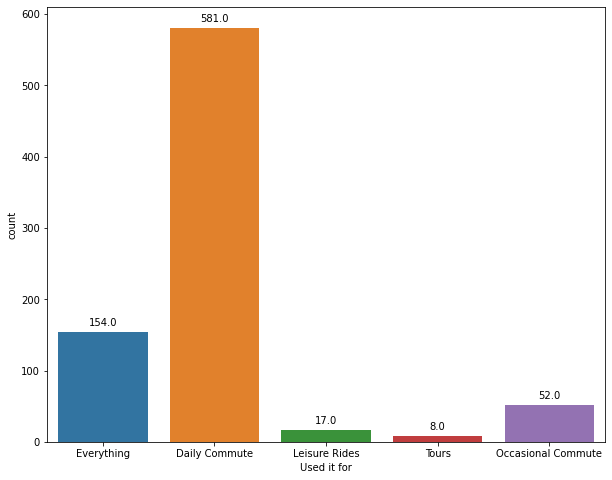

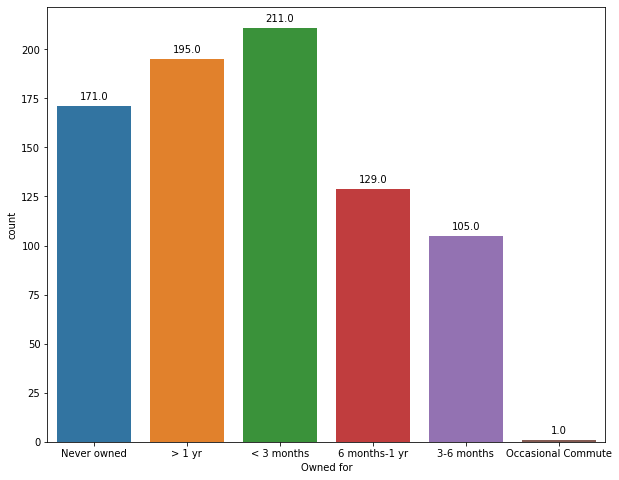

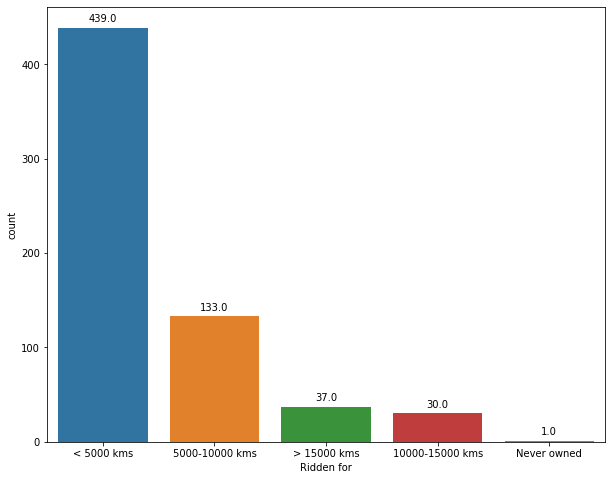

In [9]:
for col in df.columns[1:4].values:
    plt.figure(figsize=(10, 8))
    splot = sns.countplot(df[col])
    for p in splot.patches:
               splot.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
    plt.show(block=False)

# Segmentation

In [13]:
for col in df.columns:
    print(col, df[col].isnull().sum()/len(df)*100)

review 5.295566502463054
Used it for 0.0
Owned for 0.0
Ridden for 21.182266009852217
rating 0.0
Visual Appeal 12.438423645320198
Reliability 15.270935960591133
Performance 23.15270935960591
Service Experience 16.133004926108374
Extra Features 30.049261083743843
Comfort 75.1231527093596
Maintenance cost 89.16256157635468
Value for Money 89.65517241379311


In [14]:
#removing redundant/columns with many missing values
newdf = df.drop(['review', 'Comfort', 'Maintenance cost', 'Value for Money'], axis=1)

In [16]:
# Capturing NAN values with a new feature for every column

for col in newdf.columns:
    if newdf[col].isnull().sum() > 0:
        print(col)
        newdf[f'{col}_NAN']=np.where(newdf[col].isnull(),1,0)

Ridden for
Visual Appeal
Reliability
Performance
Service Experience
Extra Features


In [17]:
#filling numerical rating with rando sample imputation to preserve distribution variance 

def impute_nan(df,variable):
    ##It will have the random sample to fill the na
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample


for col in ['Visual Appeal', 'Reliability', 'Performance', 'Service Experience', 'Extra Features']:
    impute_nan(newdf, col)

In [18]:
# add a new category missing to capture the importance of missing values

def impute_nan(df,variable):
    df[variable]=np.where(df[variable].isnull(),"Missing",df[variable])

In [19]:
for feature in ['Ridden for']:
    impute_nan(newdf,feature)

In [20]:
newdf.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Ridden for_NAN,Visual Appeal_NAN,Reliability_NAN,Performance_NAN,Service Experience_NAN,Extra Features_NAN
0,Everything,Never owned,Missing,1,3.0,1.0,3.0,1.0,4.0,1,0,0,0,0,0
1,Everything,> 1 yr,< 5000 kms,5,5.0,5.0,5.0,5.0,4.0,0,0,0,0,0,1
2,Everything,< 3 months,< 5000 kms,5,4.0,4.0,5.0,3.0,4.0,0,0,0,0,0,1
3,Everything,Never owned,Missing,5,5.0,5.0,5.0,5.0,2.0,1,0,0,0,0,1
4,Daily Commute,> 1 yr,5000-10000 kms,1,2.0,1.0,1.0,2.0,1.0,0,0,0,0,0,1


In [21]:
ordinalEncoder = OrdinalEncoder()
transformed = ordinalEncoder.fit_transform(newdf.loc[:,['Used it for', 'Owned for', 'Ridden for']].values)
transformed = pd.DataFrame(transformed, columns=['Used it for', 'Owned for', 'Ridden for'])
newdf.drop(['Used it for', 'Owned for', 'Ridden for'], inplace=True, axis=1)
newdf = pd.concat([transformed, newdf], axis=1)

In [22]:
newdf.isnull().sum()

Used it for               0
Owned for                 0
Ridden for                0
rating                    0
Visual Appeal             0
Reliability               0
Performance               0
Service Experience        0
Extra Features            0
Ridden for_NAN            0
Visual Appeal_NAN         0
Reliability_NAN           0
Performance_NAN           0
Service Experience_NAN    0
Extra Features_NAN        0
dtype: int64

In [23]:
#to get the categories back
# ordinalEncoder.inverse_transform(transformed.loc[:,['Used it for', 'Owned for', 'Ridden for']].values)

## PCA and defining k for clustering

In [24]:
scaled_data = StandardScaler().fit_transform(newdf.values)

pca = PCA(n_components=0.95)

values = pca.fit_transform(scaled_data)

Silhoutte score for k = 2 is 0.2536748854915153
Silhoutte score for k = 3 is 0.333352220711222
Silhoutte score for k = 4 is 0.34505342314590925
Silhoutte score for k = 5 is 0.34606566802552047
Silhoutte score for k = 6 is 0.34413683802117634
Silhoutte score for k = 7 is 0.2860776046887743
Silhoutte score for k = 8 is 0.2867364117878027


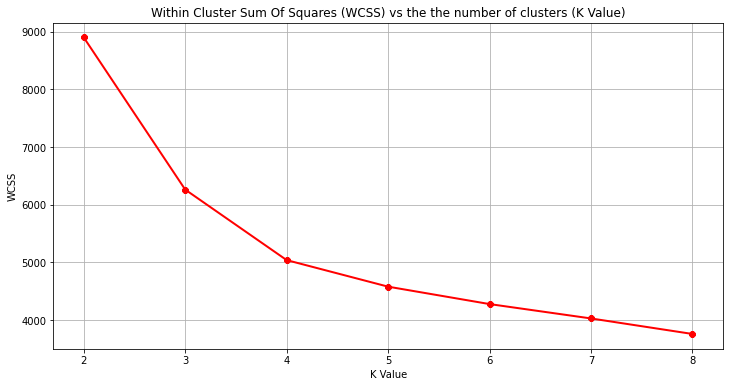

In [25]:
wcss = []
for k in range(2,9):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(values)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(values, cluster_labels)
    print(f'Silhoutte score for k = {k} is {silhouette_avg}')
    
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(2,9),wcss, linewidth=2, color="red", marker="8")
plt.xlabel("K Value")
plt.xticks(np.arange(2,9,1))
plt.title('Within Cluster Sum Of Squares (WCSS) vs the the number of clusters (K Value)')
plt.ylabel("WCSS")
plt.show()

`We clearly observe an elbow at k=3`

<function matplotlib.pyplot.show(close=None, block=None)>

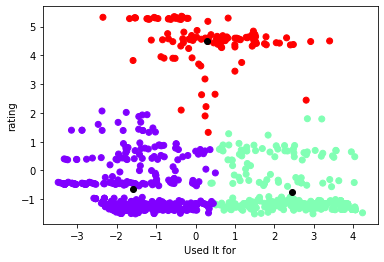

In [26]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(values)

plt.scatter(values[:,0], values[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='black')
plt.ylabel('rating')
plt.xlabel('Used It for')
plt.show

# Interpreting Segments

In [27]:
pred = kmeans.predict(values)
frame = pd.DataFrame(newdf)
frame['cluster'] = pred
frame.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,Ridden for_NAN,Visual Appeal_NAN,Reliability_NAN,Performance_NAN,Service Experience_NAN,Extra Features_NAN,cluster
0,1.0,4.0,4.0,1,3.0,1.0,3.0,1.0,4.0,1,0,0,0,0,0,1
1,1.0,3.0,2.0,5,5.0,5.0,5.0,5.0,4.0,0,0,0,0,0,1,0
2,1.0,2.0,2.0,5,4.0,4.0,5.0,3.0,4.0,0,0,0,0,0,1,0
3,1.0,4.0,4.0,5,5.0,5.0,5.0,5.0,2.0,1,0,0,0,0,1,0
4,0.0,3.0,1.0,1,2.0,1.0,1.0,2.0,1.0,0,0,0,0,0,1,1


In [28]:
newdf[['Used it for', 'Owned for', 'Ridden for']] = pd.DataFrame(ordinalEncoder.inverse_transform(newdf.loc[:,['Used it for', 'Owned for', 'Ridden for']].values), columns=['Used it for', 'Owned for', 'Ridden for'])

In [29]:
newdf.drop(['Reliability_NAN', 'Performance_NAN', 'Service Experience_NAN', 
                     'Extra Features_NAN', 'Ridden for_NAN', 'Visual Appeal_NAN'], axis=1, inplace=True)

In [30]:
newdf.head()

,Used it for,Owned for,Ridden for,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features,cluster
0,Everything,Never owned,Missing,1,3.0,1.0,3.0,1.0,4.0,1
1,Everything,> 1 yr,< 5000 kms,5,5.0,5.0,5.0,5.0,4.0,0
2,Everything,< 3 months,< 5000 kms,5,4.0,4.0,5.0,3.0,4.0,0
3,Everything,Never owned,Missing,5,5.0,5.0,5.0,5.0,2.0,0
4,Daily Commute,> 1 yr,5000-10000 kms,1,2.0,1.0,1.0,2.0,1.0,1


In [31]:
avg_df = newdf.drop(['Used it for', 'Owned for', 'Ridden for'], 
                    axis=1).groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,rating,Visual Appeal,Reliability,Performance,Service Experience,Extra Features
0,0,4.582949,4.550691,4.373272,4.384793,4.311060,4.145161
1,1,1.390335,2.479554,1.602230,2.200743,1.457249,2.215613
2,2,3.256881,3.798165,3.100917,3.495413,3.045872,3.137615


In [32]:
for col in ['Used it for', 'Owned for', 'Ridden for']:
    df2 = pd.DataFrame(newdf.groupby(['cluster',col])[col].count())
    print(df2, '\n\n')

                            Used it for
cluster Used it for                    
0       Daily Commute               290
        Everything                  104
        Leisure Rides                12
        Occasional Commute           25
        Tours                         3
1       Daily Commute               211
        Everything                   31
        Leisure Rides                 3
        Occasional Commute           22
        Tours                         2
2       Daily Commute                80
        Everything                   19
        Leisure Rides                 2
        Occasional Commute            5
        Tours                         3 


                            Owned for
cluster Owned for                    
0       3-6 months                 58
        6 months-1 yr              63
        < 3 months                122
        > 1 yr                     67
        Never owned               124
1       3-6 months                 41
        6 mon

## Main attributes of each segment:

* ### Cluster 0:
    * Average user rating is positive
    * Are mostly new owners
    * Mostly use the vehicle for daily commute
    * Haven't Ridden the vehicle Much

* ### Cluster 1:
    * Average user rating is negative
    * Are mostly long term owners
    * They also mostly use the vehicle for daily commute
    * Have ridden the vehicle for few thousand kms

* ### Cluster 2:
    * Average user rating is positive
    * Some have never owned the vehicle while others are mix of long term owners and new owners
    * They also mostly use the vehicle for daily commute
    * Haven't Ridden the vehicle Much
